## PyTorch Tutorial Part II - How to Build Your Deep Learning Project from Scratch

### We will cover:

1. Build an image classifier using LeNet
2. Train and test our model on the CIFAR-10 dataset
3. Utilities to monitor training, error analysis, visualization

### Import the Necessities

In [1]:
# -*- coding: utf-8 -*-

import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

### 1. Customize Your Own Dataset

1. Process the raw [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz), which has the structure of (after decompression) 
    + batches.meta
    + data_batch_1
    + data_batch_2
    + data_batch_3
    + data_batch_4
    + data_batch_5
    + test_batch
    + readme.html
    
   where data_batch_1-5 is for training and test_batch is for testing. We put data_batch_1-5 into a new folder called _traindata_.

In [2]:
train_raw = './cifar-10-batches-py/traindata/'
test_raw = './cifar-10-batches-py/test_batch'

In [3]:
def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='latin1')
    return dict

In [4]:
def get_train_data(train_root):
    data, labels = [], []
    for item in os.listdir(train_root):
        dict = unpickle(os.path.join(train_root, item))
        data.append(dict['data'])
        labels.extend(dict['labels'])
    train_data = np.vstack(data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return train_data, labels

In [5]:
train_data, train_labels = get_train_data(train_raw)

test_dict = unpickle(test_raw)
test_data, test_labels = test_dict['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1), np.array(test_dict['labels'])

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
train_data.shape

(50000, 32, 32, 3)

In [7]:
len(train_labels)

50000

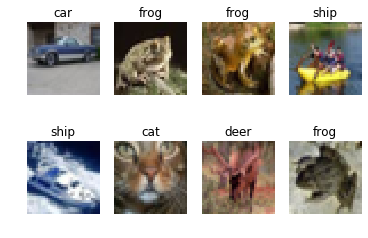

In [8]:
# sanity check

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(train_data[i])
    plt.axis('off')
    plt.title('%s' % classes[train_labels[i]])

In [9]:
test_data.shape

(10000, 32, 32, 3)

In [10]:
len(test_labels)

10000

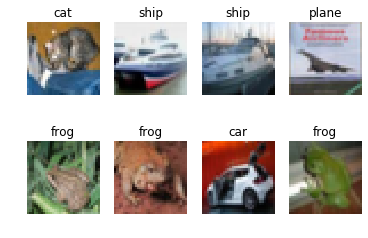

In [11]:
# sanity check

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(test_data[i])
    plt.axis('off')
    plt.title('%s' % classes[test_labels[i]])

2. Define your own dataset class

In [13]:
class CIFAR10:
    def __init__(self, root, train=True, transforms=None):
        self.root = root
        self.transform = transforms
        self.train = train
        if self.train:
            self.data, self.labels = get_train_data(self.root)
        else:
            test_dict = unpickle(self.root)
            self.data, self.labels = test_dict['data'], test_dict['labels']
            self.data = self.data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    def __getitem__(self, idx):
        
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform is not None:
            im = self.transform(img)
        return im, label
        
        
    def __len__(self):
        return len(self.data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


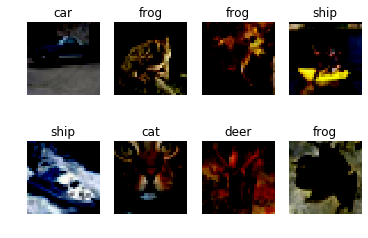

In [14]:
# transform to tensor and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root=train_raw, train=True, transforms=transform)
testset = CIFAR10(root=test_raw, train=False, transforms=transform)

# sanity check
for i in range(8):
    img, label = trainset[i]
    plt.subplot(2, 4, i+1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    plt.title('%s' % classes[label])

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=4)

### 2. Implement Your Model - LeNet

In [16]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
# test our implementation with randomly generated data as sanity check

# initialize our model
net = LeNet() 
# generate random test data, which is of shape (batch_size, channel_size, height, width)
test = torch.randn(32, 3, 32, 32)
# feed test data our network and obtain output
output = net(test)

In [19]:
output.size()

torch.Size([32, 10])

### 3. Define Loss Function and Optimizer

In [20]:
# PyTorch has already implemented many common loss functions for us
criterion = nn.CrossEntropyLoss()
# Construct an optimizer is very easy in PyTorch
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train Your Model

In [21]:
def train(epochs=3):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % 2000 == 0:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000.))
                running_loss = 0.0

    print('Finished')

In [22]:
train(epochs=3)

[1,  2000] loss: 2.202
[1,  4000] loss: 1.872
[1,  6000] loss: 1.724
[1,  8000] loss: 1.622
[1, 10000] loss: 1.553
[1, 12000] loss: 1.501
[2,  2000] loss: 1.434
[2,  4000] loss: 1.405
[2,  6000] loss: 1.370
[2,  8000] loss: 1.336
[2, 10000] loss: 1.344
[2, 12000] loss: 1.302
[3,  2000] loss: 1.236
[3,  4000] loss: 1.237
[3,  6000] loss: 1.232
[3,  8000] loss: 1.218
[3, 10000] loss: 1.206
[3, 12000] loss: 1.195
Finished


### 5. Evalution

In [23]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [24]:
test()

Accuracy of the network on the 10000 test images: 56 %


### 6. Errror Analysis

In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 70 %
Accuracy of   car : 55 %
Accuracy of  bird : 39 %
Accuracy of   cat : 52 %
Accuracy of  deer : 39 %
Accuracy of   dog : 49 %
Accuracy of  frog : 71 %
Accuracy of horse : 65 %
Accuracy of  ship : 61 %
Accuracy of truck : 63 %
